In [100]:
import matplotlib.pyplot as plt
import numpy as np
#v. 20221117.1

filedir = './data_frog/'
outputdir = './output/'
filenames = ['17.ASC']
fs = 500                        # частота дискретизации, Гц
signal_scale = 1                # коэффициент масштабирования сигнала
signal_unit = 'pA'              # единица измерения сигнала
first_stim_start_time = 1       # начало первого стимула, с
period = 8                      # период следования стимулов, с
background_start_time = 5       # начало фоновой засветки, с
background_duration = 40        # длительность фоновой засветки, с
sign = -1                        # полярность {1:'стимулы вверх', -1:'стимулы вниз'}
low_cutoff = 0.1                # частота среза highpass фильтра, Гц
stims_to_delete = []            # номера неудачных стимулов (перечислить через запятую)
stims_to_export = []            # номера стимулов для экспорта в файл (пример: [(0, 2), 25] - с 0 по 2, 25)
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period

In [101]:
# Чтение сигнала из файла(ов)

signal = []
filesizes = [] # количество точек в файлах
for filename in filenames:
    with open(filedir + filename, 'r', encoding='utf-8') as file:
        filesizes.append(0)
        file.readline()
        line = file.readline()
        while line and line[0] == '"':
            line = file.readline()
        signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
        filesizes[-1] += 1
        for line in file:
            signal.append(sign * signal_scale * float('0' if line == '.\n' else line))
            filesizes[-1] += 1
signal = np.array(signal)

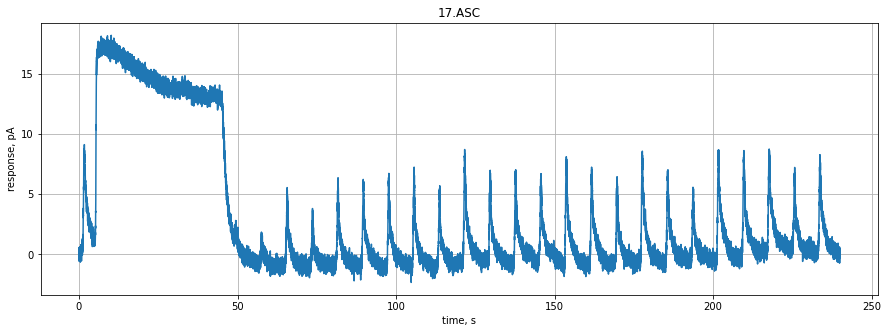

In [102]:
# Построение графика сигнала

n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(','.join(filenames))
ax.grid()

In [103]:
# Расчет количества стимулов

# Последний стимул в каждом файле исключается, так как нет гарантии, что длина файла будет кратна периоду стимулов.
# Если длина файла не кратна периоду, то последний стимул может быть обрезан концом файла.
stims_cnt = (filesizes[0] // fs - after_background_start_time) // period
begin = after_background_start_time
stims_t = []
for i in range(stims_cnt):
    stims_t.append(begin + i * period)
pos = 0
for i in range(1, len(filesizes)):
    file_stims_cnt = (filesizes[i] // fs - first_stim_start_time) // period
    stims_cnt += file_stims_cnt
    pos += filesizes[i - 1] // fs
    begin = pos + first_stim_start_time
    for j in range(file_stims_cnt):
        stims_t.append(begin + j * period)
stims_t = np.array(stims_t)

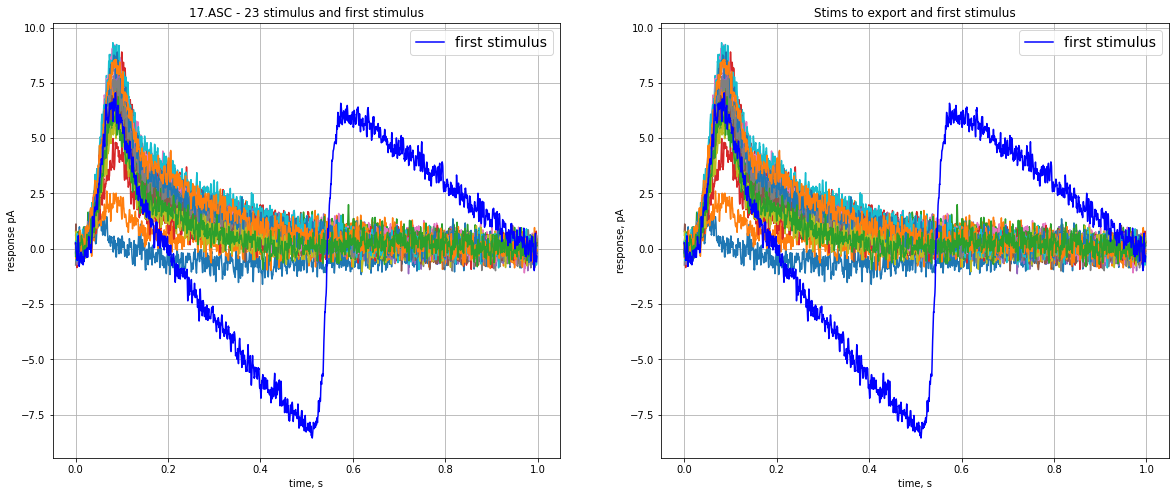

In [104]:
# Выделение стимулов и вычитание тренда из стимулов

stims = []
prefix = fs // 5 # 0.2 секунды слева от стимула используются для расчета тренда
postfix = fs // 5 # последние 0.2 секунды стимула используются для расчета тренда
size = period * fs + prefix

# вычитание тренда из стимулов
for i in range(stims_cnt):
    begin = stims_t[i] * fs - prefix
    end = begin + size
    stim = np.array(signal[begin:end])
    temp_t = np.linspace(0, (size - 1), size)
    x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
    y = np.concatenate([stim[:prefix], stim[size - postfix:]])
    s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
    k, b = s[1], s[0]
    trend = k * temp_t + b
    stim = stim - trend
    stim = stim[prefix:]
    stims.append(stim)

# вычитание тренда из первого стимула
begin = first_stim_start_time * fs - prefix
end = begin + size
first_stim = np.array(signal[begin:end])
temp_t = np.linspace(0, (size - 1), size)
x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
y = np.concatenate([first_stim[:prefix], first_stim[size - postfix:]])
s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
k, b = s[1], s[0]
trend = k * temp_t + b
first_stim = first_stim - trend
first_stim = first_stim[prefix:]
first_stim_max = first_stim.max()

size -= prefix
temp_t = np.linspace(0, 1 - 1 / fs, size)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
for stim in stims:
    ax1.plot(temp_t, stim)
ax1.plot(temp_t, first_stim, 'b', label='first stimulus')
ax1.legend(prop={"size": 14})
ax1.set_xlabel('time, s')
ax1.set_ylabel('response ' + signal_unit)
ax1.set_title(f'{",".join(filenames)} - {stims_cnt} stimulus and first stimulus')
ax1.grid()

numbers = set()
if not stims_to_export:
    numbers = set(range(stims_cnt))
else:
    for number in stims_to_export:
        if type(number) is tuple:
            numbers |= set(range(number[0], min(number[1] + 1, stims_cnt)))
        else:
            if number < stims_cnt:
                numbers.add(number)
stims_to_export = list(sorted(numbers))
for number in stims_to_export:
    ax2.plot(temp_t, stims[number])
ax2.plot(temp_t, first_stim, 'b', label='first stimulus')
ax2.legend(prop={"size": 14})
ax2.set_xlabel('time, s')
ax2.set_ylabel('response, ' + signal_unit)
ax2.set_title('Stims to export and first stimulus')
ax2.grid()

In [105]:
# Аппроксимация максимумов стимулов экспонентой

from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

stims_maximums = np.array([stim.max() for stim in stims])

# Считается расстояние между началом первого импульса после фоновой засветки и ее концом
# График максимумов стимулов начинает строится в точке, равной рассчитанному расстоянию
stims_t -= background_start_time + background_duration


print('Номер\tВремя\tМаксимум')
for i, (x, stim_maximum) in enumerate(zip(stims_t, stims_maximums)):
    print(f'{i}\t{x}\t{stim_maximum:.4f}')

Номер	Время	Максимум
0	4	1.4798
1	12	2.6119
2	20	6.5048
3	28	4.9861
4	36	7.2945
5	44	7.3641
6	52	7.8297
7	60	8.4698
8	68	6.6257
9	76	9.3212
10	84	7.5711
11	92	7.8326
12	100	7.3597
13	108	9.0986
14	116	8.1328
15	124	7.1079
16	132	9.2204
17	140	7.7202
18	148	5.8814
19	156	9.2374
20	164	8.8964
21	172	8.5651
22	180	6.7310


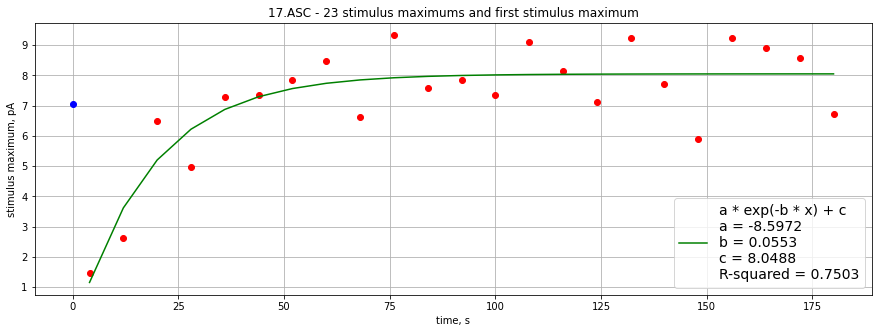

In [106]:
# Удаление неудачных стимулов
stims_maximums = np.delete(stims_maximums, stims_to_delete)
stims_t = np.delete(stims_t, stims_to_delete)

# Аппроксимация
popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, stims_t, stims_maximums, [-10, 0.01, 10])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию. Подберите начальные коэффициенты.')
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
fit = func(stims_t, *popt)
rvalue = stats.linregress(stims_maximums, fit).rvalue
r_squared = rvalue ** 2

# Построение графика экспоненты
fig, ax = plt.subplots()
ax.plot(stims_t, stims_maximums, 'ro')
ax.plot(0, first_stim_max, 'bo')
ax.plot(stims_t, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a:.4f}\n'
                           f'b = {exp_b:.4f}\n'
                           f'c = {exp_c:.4f}\n'
                           f'R-squared = {r_squared:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum, ' + signal_unit)
ax.set_title(f'{",".join(filenames)} - {stims_maximums.size} stimulus maximums and first stimulus maximum')
ax.legend(prop={"size": 14})
ax.grid()

In [107]:
# Сохранение результатов в файлы
from pathlib import Path

Path(outputdir).mkdir(parents=True, exist_ok=True)
# Сохранение максимумов стимулов
with open(f'{outputdir}{",".join(filenames)}_out.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write(f'Параметр экспоненты a\t{exp_a:.4f}\n')
    file.write(f'Параметр экспоненты b\t{exp_b:.4f}\n')
    file.write(f'Параметр экспоненты c\t{exp_c:.4f}\n')
    file.write(f'Постоянная времени 1/b\t{1 / exp_b:.4f}\n')
    file.write(f'R-squared\t{r_squared:.4f}\n')
    file.write('\n')
    file.write('time, с\tU, у.е\tфункция аппроксимации (a * exp(-b * x) + c)\n')
    file.write(f'{0}\t{first_stim_max}\n')
    for i in range(stims_maximums.size):
        file.write(f'{stims_t[i]}\t{stims_maximums[i]}\t{fit[i]}\n')

# Сохранение стимулов
with open(f'{outputdir}{",".join(filenames)}_resp.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write('\n')
    file.write('time, с\tОпорный\t')
    for number in stims_to_export:
        file.write(f'{number}\t')
    file.write('\n')
    size = first_stim.size
    temp_t = np.linspace(0, 1 - 1 / fs, size)
    for i in range(size):
        file.write(f'{temp_t[i]:.4f}\t{first_stim[i]}\t')
        for number in stims_to_export:
            file.write(f'{stims[number][i]}\t')
        file.write('\n')

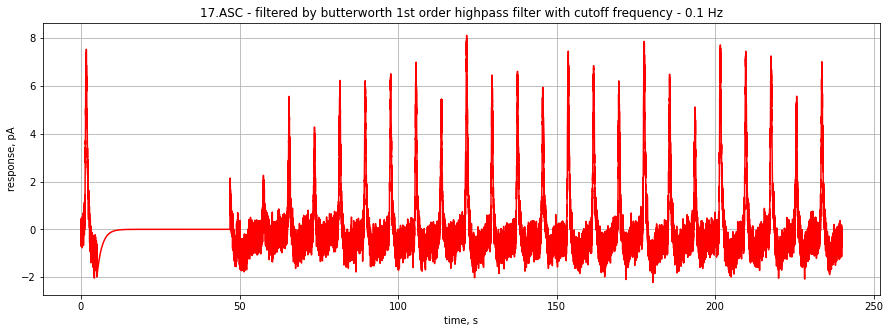

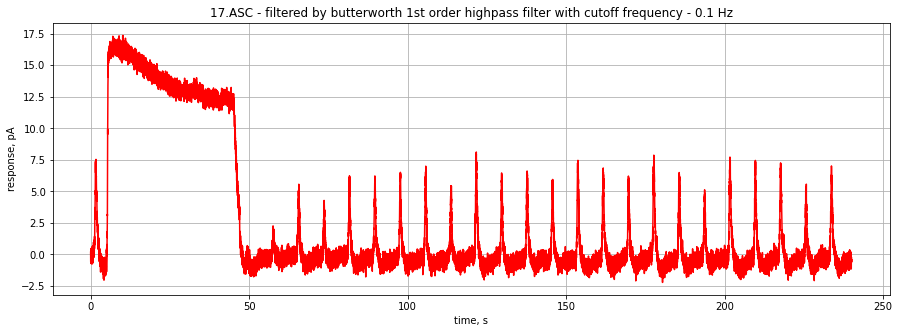

In [108]:
# Следующий блок кода используется только в целях красивого построения графика сигнала, отфильтрованного highpass фильтром Баттерворта.
# В расчетах максимумов стимулов и экспоненты отфильтрованный сигнал не участвует,
# так как фильтр немного обрезает максимум стимулов и добавляет отрицательный зубец на нисходящем фронте стимула

# Смещение сигнала до начала фона к 0
signal[:background_start_time * fs] -= signal[:first_stim_start_time * fs].mean()
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
# Копия фона - необходима, чтобы его потом нарисовать вместе с отфильтрованным сигналом
background = np.array(signal[begin:end])
# Смещение сигнала после окончания фона к 0
signal[end:] -= signal[end:after_background_start_time * fs].mean()
# Удаление фона, для того чтобы избежать переходного процесса фильтра после него и измерить высоту первого после него стимула
signal[begin:end] = 0

from scipy.signal import butter, lfilter
nyq = 0.5 * fs
b, a = butter(1, low_cutoff / nyq, btype='highpass', analog=False)
filtered = lfilter(b, a, signal)
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()

# Возврат ступеньки, смещенной к нулю, в отфильтрованный сигнал, просто чтобы ее нарисовать
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
filtered[begin:end] = background - background[0]
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response, ' + signal_unit)
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()